In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
kb = 0.69503 #cm^-1*K

class IRspectrum(object):
    """
    A class for defining and plotting IR spectra.
    
    """
    def __init__(self, name="CO", B=1.9346, D=1e-6, \
                 nue=2169.8, Xe=6.12e-3, alfae=1.75e-2, jmax=30,\
                T=300.0):            
        """
        Parameters
        ----------
        name : str
            Molecule name
        B : float
           Rotational constant (cm-1)
        D : float
            Constant for centrifugal distortion (cm-1)
        nue : float
            Vibrational frequency (cm-1)
        Xe : float
            Anharmonicity constant 
        alfae : float
            Roto-vibrational coupling constant
        jmax : int
            Maximum value of J
        """
        self.name = name
        self.B = B
        self.D = D
        self.nue = nue
        self.Xe = Xe
        self.alfae = alfae
        self.jmax = jmax
        self.T = T
        self.calc_nu_RotVib()
        self.generate_weights()
    
    def calc_nu_RotVib(self):
        """
        Calculates frequencies for P, Q and R branches

        """
        jmax = self.jmax
        nu_RotVib = np.zeros([2*jmax+2])
    
        nuP = self.calc_nu_RotVib_branch("P")
        nuQ = self.calc_nu_RotVib_branch("Q")
        nuR = self.calc_nu_RotVib_branch("R")
    
        for J in range(0, jmax):
            nu_RotVib[J]= nuP[jmax-J-1]
        nu_RotVib[jmax]=nuQ[0]

        for J in range(self.jmax+1, 2*jmax+2):
            nu_RotVib[J]= nuR[J-jmax-1]
        self.nu_RotVib = nu_RotVib

    def FRot(self, J):
        """
        Defines rotational energy
        
        """
        FRot = self.B*J*(J+1) - self.D*(J*(J+1))**2
        return FRot

    def GVib(self, v=1):
        """
        Defines vibrational energy as determined by 
        quantum number v.
    
        """
        GVib = self.nue*(v + 0.5) - self.Xe*self.nue*(v+0.5)**2 
        return GVib
    
    def SRotVib(self, v, J):
        """
        Calculates sum of rotational and vibrational energies

        """
        SRotVib = self.GVib(v) + self.FRot(J) - self.alfae*(v+0.5)*J*(J+1)
        return SRotVib

    def calc_nu_RotVib_branch(self, branch):
        """ 
        Calculates roto-vibrational spectrum
    
        """
        jmax = self.jmax
        if branch == "P" :
            nu_branch = np.zeros([jmax])
            for J in range(1, jmax+1):
                 nu_branch[J-1]= self.SRotVib(1,J-1) - self.SRotVib(0,J)
        elif branch == "Q":
            nu_branch = np.zeros([1])
            nu_branch[0] = self.SRotVib(1,0) - self.SRotVib(0,0)
        elif branch == "R":
            nu_branch= np.zeros([jmax+1])
            for J in range(0,jmax+1):
                 nu_branch[J]= self.SRotVib(1,J+1) - self.SRotVib(0,J)
        return nu_branch 
    
    def NJ(self, J):
        """
        Calculates Boltzmann weight for rotational level J.
        
        """
        NJ = (2.0*J+1.0)*np.exp(-1.0*self.FRot(J)/(kb*self.T))
        return NJ
    
    def calc_qRot(self):
        """
        Calculates rotational partition function
        
        """        
        qRot = 0.0
        for J in range(0, self.jmax+1):
            qRot = qRot + (2.0*J+1.0)*np.exp(-1.0*self.FRot(J)/(kb*self.T))
        return qRot    
    
    def generate_weights(self):
        """ 
        Assigns weights to peaks

        """
        jmax = self.jmax
        qRot = self.calc_qRot()
        w_RotVib = np.zeros([2*jmax+2])
        #P branch
        for J in range(0, jmax):
            JIni = jmax-J
            w_RotVib[J] =  self.NJ(JIni)/qRot
        # Q branch
        w_RotVib[jmax] = 0.0
        # R branch
        for J in range(jmax+1, 2*jmax+2):
            JIni = J-jmax-1
            w_RotVib[J] = self.NJ(JIni)/qRot
        self.w_RotVib = w_RotVib

    def create_spectra(self):
        """
        Creates IR spectrum
        
        """
        nu = self.nu_RotVib
        w = self.w_RotVib
        sigma = 1.0
        npuntos = 10000
        wa = 0.01
        numin = np.min(nu) -20.0
        numax = np.max(nu) +20.0
        rango = numax-numin
        paso = float(rango)/float(npuntos)
        xx = np.zeros([npuntos+1])
        yy = np.zeros([npuntos+1])
        freq=numin
        for i in range(0,npuntos+1):
            freq=freq+paso*(1.0-wa/2.0)
            fw=0.0                   
            for k in range(0,len(nu)):
                fw = fw + w[k]/(1+4*(freq - nu[k])*(freq-nu[k])/(sigma*sigma))
            xx[i]=freq
            yy[i]=fw
        self.make_plot1(xx,yy)
        return
    
    def make_plot1(self, xx,yy):
        """
        Plots IR spectrum
        
        """
        plt.figure()
        plt.plot(xx, yy, 'b')
        plt.title('Roto-vibrational spectrum for: %s'%self.name, color='r', fontsize=14)
        plt.text(xx[10], 0.5*max(yy),"B = " + str(self.B) + " cm"r'$^{-1}$'"\n" + \
                              "D = " + str(self.D) + " cm"r'$^{-1}$'"\n" + \
                              r'$\nu_e = $' + str(self.nue) + " cm"r'$^{-1}$'"\n" + \
                              r'$\chi_e = $' + str(self.Xe) + "\n" + \
                              r'$\alpha_e = $' + str(self.alfae) \
                              , color='k')
        plt.xlabel(r'$\nu$ (cm$^{-1}$)', fontsize=14)
        plt.ylabel('Intensity', fontsize=14)

        plt.tight_layout()
        return

In [11]:
COspec = IRspectrum(T=300)

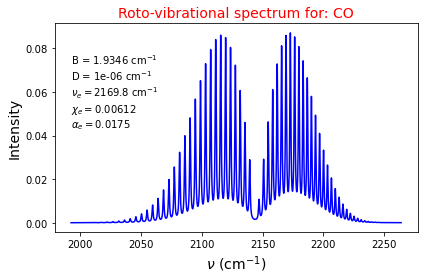

In [12]:
COspec.create_spectra()

In [20]:
COspec = IRspectrum(T=700)

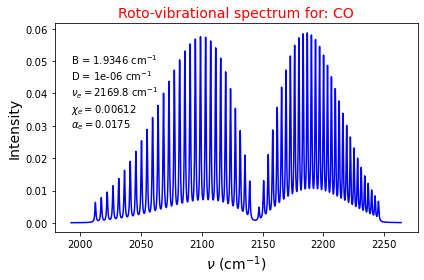

In [21]:
COspec.create_spectra()

In [7]:
COspec = IRspectrum(T=10)

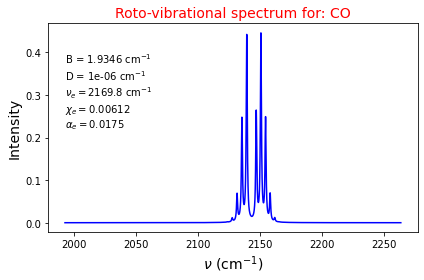

In [8]:
COspec.create_spectra()